In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Subset

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import time
import copy

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [3]:
def get_datasets():

    # Resize
    transform_std = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    transform_mnist = transforms.Compose([
        transforms.Resize(224),
        transforms.Grayscale(num_output_channels=3), # Convert to 3 channels
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), 
    ])

    cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_std)
    cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_std)

    mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
    mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)
    
    datasets = {
        'CIFAR-10': {'train': cifar10_train, 'test': cifar10_test, 'classes': cifar10_train.classes},
        'MNIST': {'train': mnist_train, 'test': mnist_test, 'classes': mnist_train.classes}
    }
    
    return datasets

In [4]:
def get_model(num_classes):

    model = models.vgg16(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    model.classifier[0] = nn.Linear(512 * 7 * 7, 4096) 
    model.classifier[3] = nn.Linear(4096, 1024)
    model.classifier[6] = nn.Linear(1024, num_classes)

    return model.to(device)

In [5]:
def plot_curves(history, dataset_name, model_name):
    """Plots training & validation accuracy and loss curves."""
    plt.figure(figsize=(12, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'Accuracy Curves: {model_name} on {dataset_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves: {model_name} on {dataset_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes, dataset_name, model_name):
    """Generates and plots a confusion matrix heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix: {model_name} on {dataset_name}')
    plt.show()

def plot_roc_auc(y_true, y_score, n_classes, classes, dataset_name, model_name):
    """Plots ROC curves and calculates AUC for each class."""
    # Binarize the output
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC): {model_name} on {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

In [6]:
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    
    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model, history

In [7]:
def get_predictions(model, dataloader):
    model.eval()
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            scores = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds = torch.cat((all_preds, preds), dim=0)
            all_labels = torch.cat((all_labels, labels), dim=0)
            all_scores = torch.cat((all_scores, scores), dim=0)
            
    return all_labels.cpu().numpy(), all_preds.cpu().numpy(), all_scores.cpu().numpy()

In [8]:
def main():
    datasets = get_datasets()
    model_names = ['VGG16']
    split_sizes = [0.6, 0.7, 0.8]
    num_epochs = 10
    
    for dataset_name, dataset_info in datasets.items():
        print(f"\n{'='*20} DATASET: {dataset_name} {'='*20}")
        train_dataset = dataset_info['train']
        test_dataset = dataset_info['test']
        classes = dataset_info['classes']
        num_classes = len(classes)
        
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        for model_name in model_names:
            print(f"\n{'--'*10} MODEL: {model_name} {'--'*10}")
            
            overall_best_accuracy = 0.0
            best_case_results = {}
            best_split_size = 0
            
            for split in split_sizes:
                print(f"\n--- Training with {int(split*100)}% of data ---")
                
                num_train = len(train_dataset)
                indices = list(range(num_train))
                np.random.shuffle(indices)
                split_idx = int(np.floor(split * num_train))
                train_idx = indices[:split_idx]
                train_subset = Subset(train_dataset, train_idx)
                
                num_subset_train = len(train_subset)
                val_split = 0.2
                val_idx_end = int(np.floor(val_split * num_subset_train))
                val_indices = list(range(num_subset_train))
                np.random.shuffle(val_indices)
                
                final_train_indices = val_indices[val_idx_end:]
                val_indices = val_indices[:val_idx_end]
                
                final_train_subset = Subset(train_subset, final_train_indices)
                val_subset = Subset(train_subset, val_indices)
                
                train_loader = DataLoader(final_train_subset, batch_size=32, shuffle=True)
                val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

                # Train
                model = get_model(num_classes)
                criterion = nn.CrossEntropyLoss()
                params_to_update = [param for param in model.parameters() if param.requires_grad]
                optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
                
                trained_model, history = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs)
                
                # Evaluate
                y_true, y_pred, _ = get_predictions(trained_model, test_loader)
                test_accuracy = np.mean(y_true == y_pred)
                print(f"Final Test Accuracy for {int(split*100)}% split: {test_accuracy:.4f}")

                if test_accuracy > overall_best_accuracy:
                    print(f"*** New best model found with accuracy: {test_accuracy:.4f} ***")
                    overall_best_accuracy = test_accuracy
                    best_split_size = split
                    best_case_results['model'] = trained_model
                    best_case_results['history'] = history

            if 'model' in best_case_results:
                print(f"\n--- Generating plots for best case (from {int(best_split_size*100)}% split with {overall_best_accuracy:.4f} accuracy) ---")
                best_model = best_case_results['model']
                best_history = best_case_results['history']
                
                plot_curves(best_history, dataset_name, model_name)
                
                y_true, y_pred, y_score = get_predictions(best_model, test_loader)
                plot_confusion_matrix(y_true, y_pred, classes, dataset_name, model_name)
                plot_roc_auc(y_true, y_score, num_classes, classes, dataset_name, model_name)

100%|██████████| 170M/170M [00:11<00:00, 15.4MB/s] 
100%|██████████| 9.91M/9.91M [00:01<00:00, 6.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.13MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



==================== DATASET: CIFAR-10 ====================

-------------------- MODEL: VGG16 --------------------

--- Training with 60% of data ---


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 208MB/s] 


Epoch 1/10
----------
train Loss: 0.9874 Acc: 0.6725
val Loss: 0.5320 Acc: 0.8122
Epoch 2/10
----------
train Loss: 0.4492 Acc: 0.8445
val Loss: 0.4420 Acc: 0.8413
Epoch 3/10
----------
train Loss: 0.3133 Acc: 0.8934
val Loss: 0.4264 Acc: 0.8475
Epoch 4/10
----------
train Loss: 0.2202 Acc: 0.9259
val Loss: 0.4457 Acc: 0.8457
Epoch 5/10
----------
train Loss: 0.1503 Acc: 0.9512
val Loss: 0.4713 Acc: 0.8495
Epoch 6/10
----------
train Loss: 0.0960 Acc: 0.9720
val Loss: 0.4651 Acc: 0.8558
Epoch 7/10
----------
train Loss: 0.0609 Acc: 0.9845
val Loss: 0.4892 Acc: 0.8545
Epoch 8/10
----------
train Loss: 0.0397 Acc: 0.9909
val Loss: 0.5215 Acc: 0.8523
Epoch 9/10
----------
train Loss: 0.0285 Acc: 0.9946
val Loss: 0.5369 Acc: 0.8545
Epoch 10/10
----------
train Loss: 0.0199 Acc: 0.9972
val Loss: 0.5563 Acc: 0.8567
Best val Acc: 0.856667
Final Test Accuracy for 60% split: 0.8606
*** New best model found with accuracy: 0.8606 ***

--- Training with 70% of data ---
Epoch 1/10
----------
train 

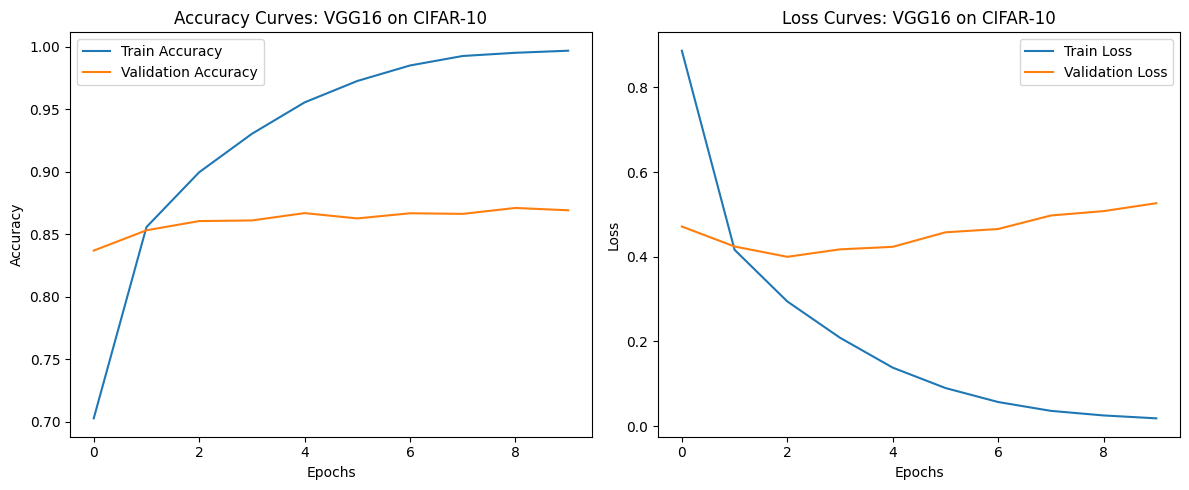

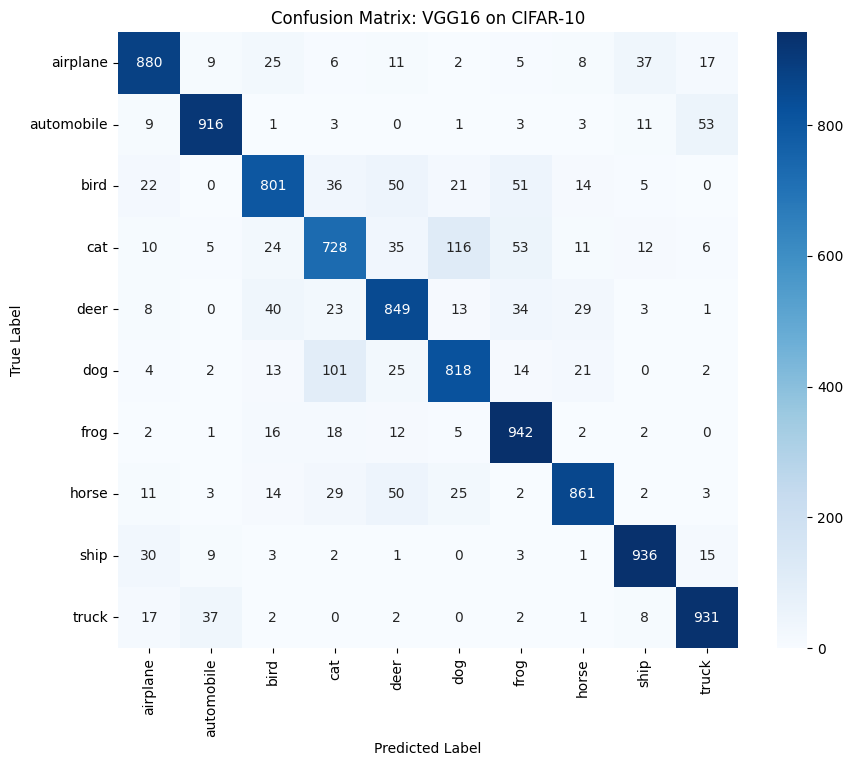

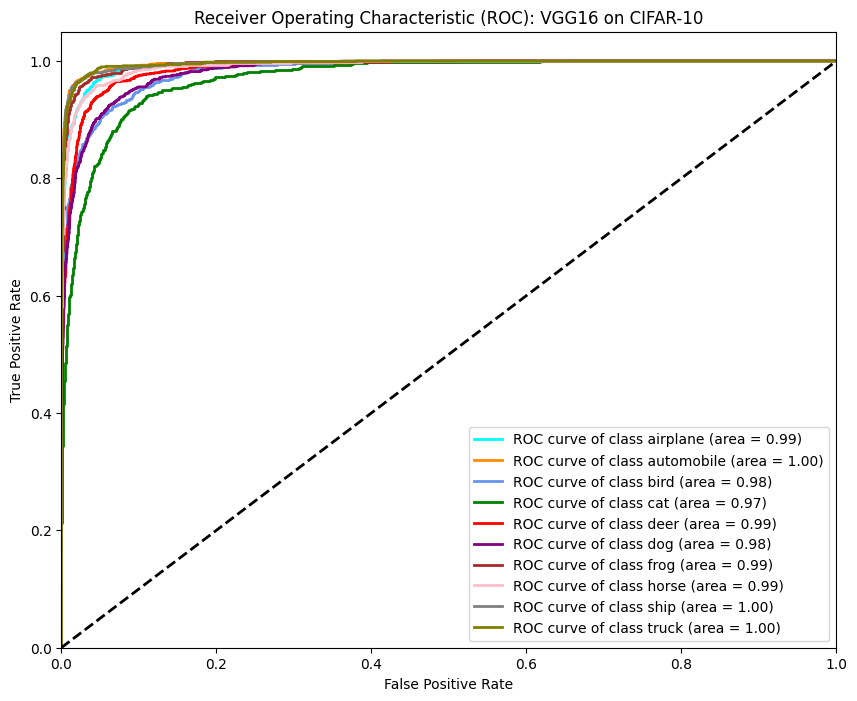


==================== DATASET: MNIST ====================

-------------------- MODEL: VGG16 --------------------

--- Training with 60% of data ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
train Loss: 0.3939 Acc: 0.9118
val Loss: 0.0660 Acc: 0.9793
Epoch 2/10
----------
train Loss: 0.0704 Acc: 0.9793
val Loss: 0.0499 Acc: 0.9831
Epoch 3/10
----------
train Loss: 0.0484 Acc: 0.9857
val Loss: 0.0433 Acc: 0.9864
Epoch 4/10
----------
train Loss: 0.0384 Acc: 0.9888
val Loss: 0.0424 Acc: 0.9867
Epoch 5/10
----------
train Loss: 0.0312 Acc: 0.9914
val Loss: 0.0367 Acc: 0.9878
Epoch 6/10
----------
train Loss: 0.0252 Acc: 0.9926
val Loss: 0.0353 Acc: 0.9878
Epoch 7/10
----------
train Loss: 0.0225 Acc: 0.9940
val Loss: 0.0344 Acc: 0.9881
Epoch 8/10
----------
train Loss: 0.0184 Acc: 0.9951
val Loss: 0.0353 Acc: 0.9892
Epoch 9/10
----------
train Loss: 0.0152 Acc: 0.9962
val Loss: 0.0348 Acc: 0.9883
Epoch 10/10
----------
train Loss: 0.0137 Acc: 0.9965
val Loss: 0.0341 Acc: 0.9889
Best val Acc: 0.989167
Final Test Accuracy for 60% split: 0.9910
*** New best model found with accuracy: 0.9910 ***

--- Training with 70% of data ---
Epoch 1/10
----------
train 

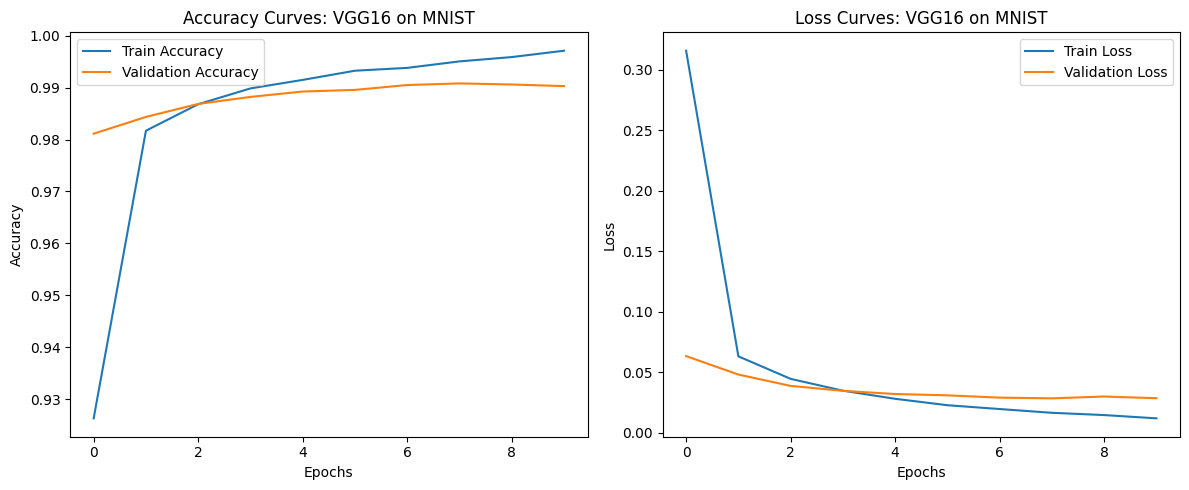

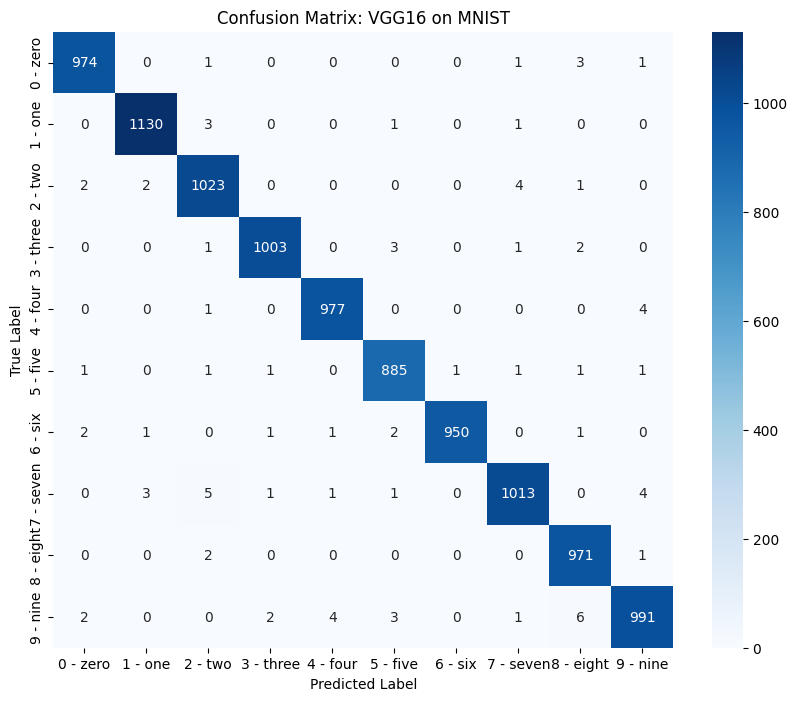

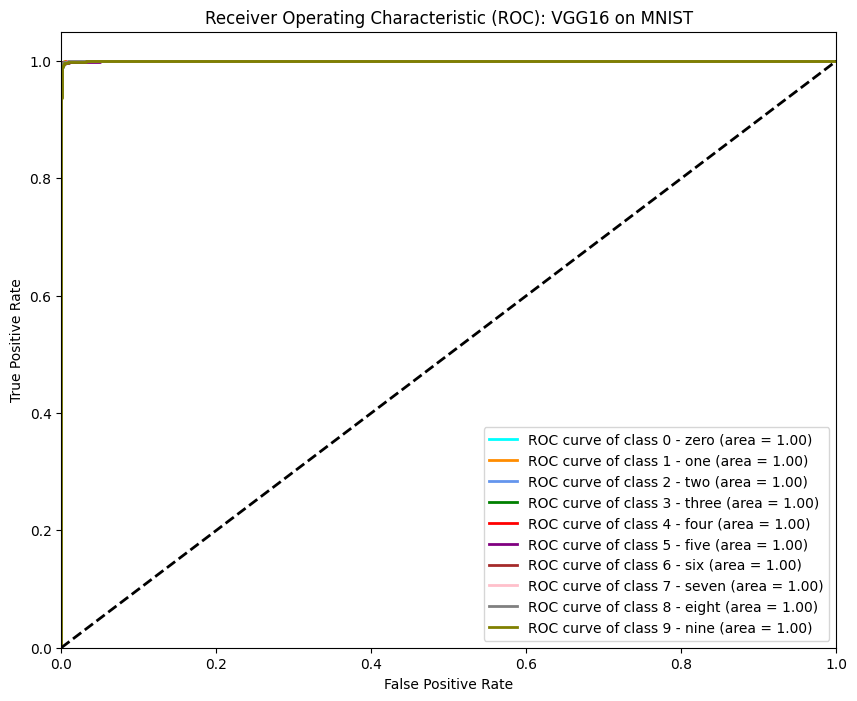

In [9]:
if __name__ == '__main__':
    main()